# Sentiment Classification of IMDB Movie Reviews Using NLP

### 1. Project description

Film Junky Union, a cutting-edge community for classic movie enthusiasts, is developing a system to filter and categorize film reviews.
Your objective is to train a model capable of automatically detecting negative reviews.
To achieve this, you will use a dataset of IMDB movie reviews with labeled sentiment polarity to build a classifier that distinguishes between positive and negative reviews.
The model should achieve a minimum F1-score of 0.85.

## Environment Setup and Requirements

In [1]:
import re
import math

import joblib
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import transformers

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
import torch
print("CUDA disponible:", torch.cuda.is_available())

CUDA disponible: False


In [4]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
#Cache cleanse before running model
torch.cuda.empty_cache()
print(f"Memoria antes: {torch.cuda.memory_allocated() / 1e6} MB")
torch.cuda.empty_cache()
print(f"Memoria después: {torch.cuda.memory_allocated() / 1e6} MB")

Memoria antes: 0.0 MB
Memoria después: 0.0 MB


In [ ]:
# https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## 2. Data Loading and Exploration

In [7]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [8]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [10]:
#Eliminar columnas innecesarias para los modelos
df_reviews = df_reviews.drop(columns=['primary_title', 'original_title', 'end_year', 'idx'])

In [11]:
# Eliminar duplicados basados en la columna 'review'
df_reviews = df_reviews.drop_duplicates(subset=['review']).reset_index(drop=True)

In [12]:
df_reviews = df_reviews.dropna(subset=['average_rating', 'votes','review', 'rating']) # Eliminamos valores nulos

In [13]:
# Cargar spaCy en inglés (sin parser ni NER)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [14]:
#Tipos de datos incorrectos
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')

In [15]:
print(df_reviews.sample(5, random_state=12345))

          tconst title_type  start_year  runtime_minutes  is_adult  \
28812  tt0114287      movie        1995            139.0         0   
7438   tt0896798      movie        2007             88.0         0   
17298  tt0455538      movie        2008            110.0         0   
36951  tt0122070      movie        1982             85.0         0   
6351   tt0238112      movie        2001            131.0         0   

                          genres  average_rating  votes  \
28812  Adventure,Biography,Drama             6.9  39765   
7438      Crime,Mystery,Thriller             6.1  36745   
17298     Biography,Comedy,Drama             6.4  67071   
36951            Horror,Thriller             3.8    993   
6351         Drama,Music,Romance             5.9  32387   

                                                  review  rating   sp  pos  \
28812  From the excellent acting of an extremely impr...      10  pos    1   
7438   Not even original in the plot. Ho hum. There w...       4  ne

## 3. EDA (Exploratory data analysis)

Veamos el número de películas y reseñas a lo largo de los años.

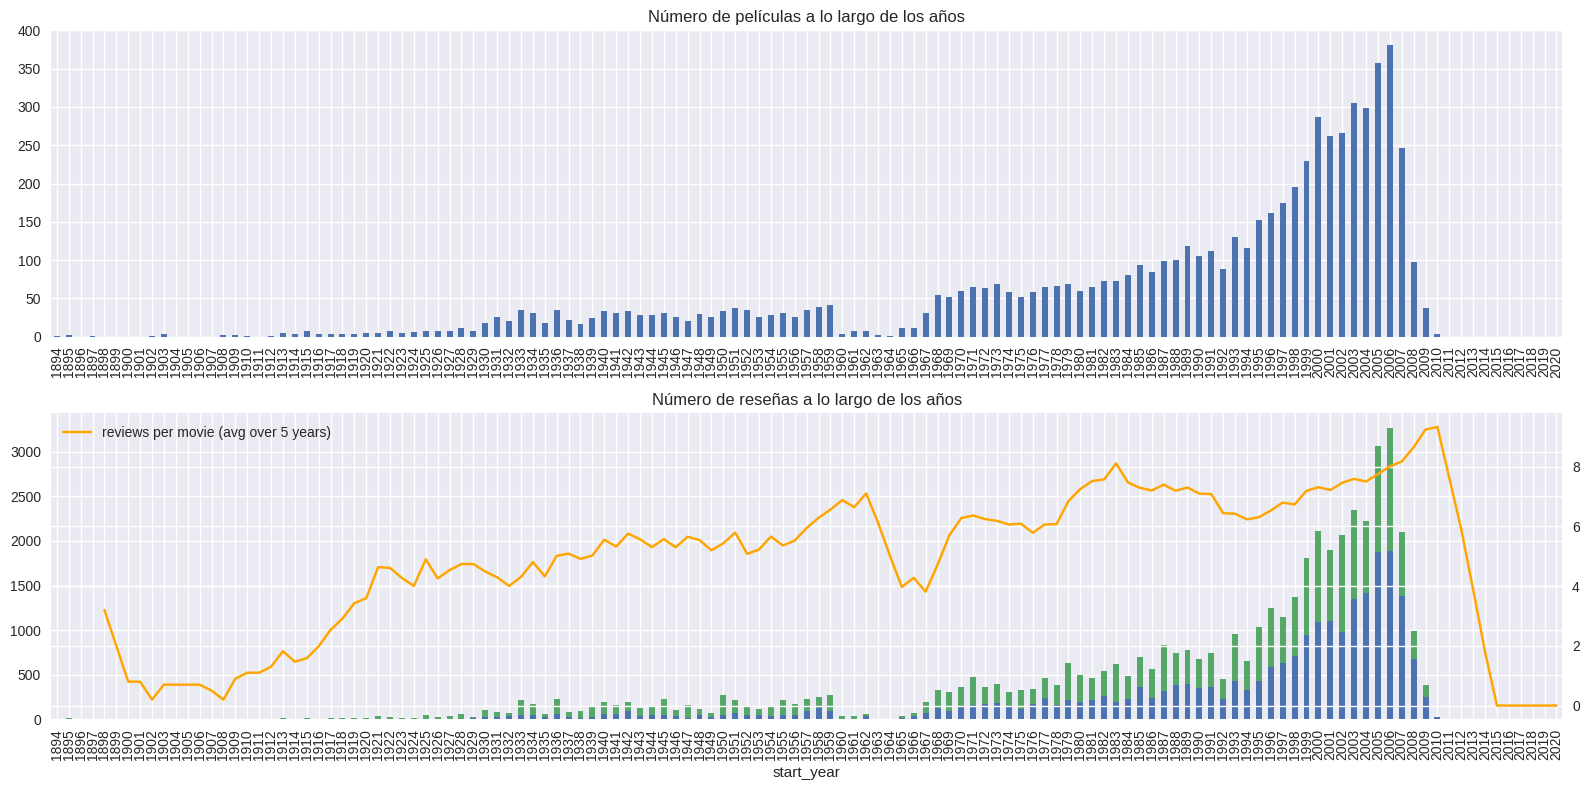

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

The analysis of temporal distribution shows how the availability and accessibility of reviews has changed over time. While in the early decades of cinema, reviews were scarce, the advent of the internet allowed for a democratization of film criticism, significantly increasing the volume of reviews analyzed in this study.

Let's look at the distribution of the number of reviews per movie with the exact count and KDE (just to know how it may differ from the exact count)

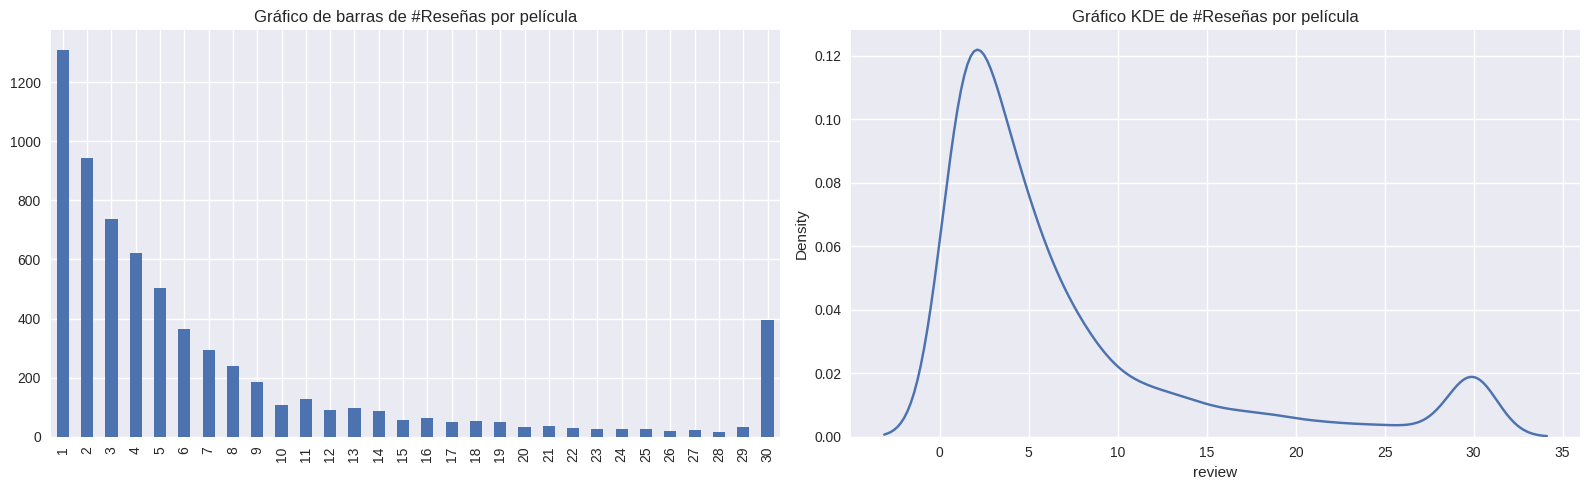

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

# Analysis of the Distribution of Reviews by Movie
Both the bar chart and the KDE chart of reviews per movie show a rightward skew, indicating that most movies receive between 1 and 8 reviews, while only a few reach up to 30 reviews.

**Interpretation of the Results**
This behavior suggests that the review frequency is uneven and is dominated by a small group of movies with many reviews, while the majority receive few. This could be due to several factors:

**Uneven Popularity:** Some movies generate more interest and discussion, while others go unnoticed.
Sporadic Participation: Users do not review movies consistently, but only occasionally.
Highly Active Users: There may be a subset of users who review many movies, generating the long tails in the distribution.

In [18]:
df_reviews['pos'].value_counts()

0    23680
1    23558
Name: pos, dtype: int64

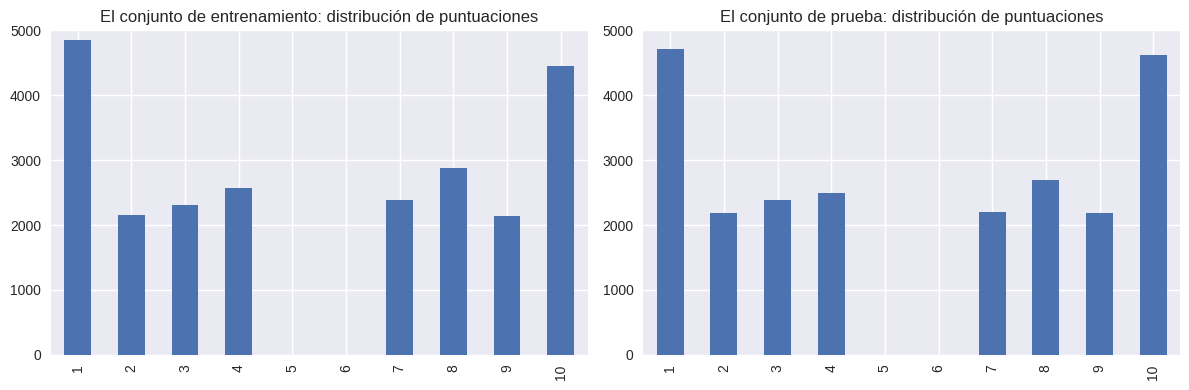

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

# Analysis of Score Distribution in the Training and Test Sets

The bar chart reveals that the distribution of scores in the training and test sets is practically identical, indicating that the data was correctly stratified during the split. Regarding the frequency of each score, the following can be observed:

- 1 and 10 are the most common values, with approximately 5,000 and 4,500 reviews, respectively.
- 2 and 9 have a lower presence, with approximately 2,000 and 200 reviews, respectively.
- 3, 4, 7, and 8 have a more irregular distribution, with 3 and 7 showing a drop after 2,500, while 8 increases near 3,000.
- Scores 5 and 6 are completely absent from the dataset.

**Interpretation of Results:**
This pattern suggests that audiences tend to express their opinions clearly about films, either very positive (10) or very negative (1). The lack of intermediate scores (5 and 6) reinforces the idea that reviews reflect polarized views rather than balanced assessments.

From a modeling perspective, this means that review classification will essentially be reduced to differentiating between strongly positive and negative opinions, which can simplify the problem but also introduce bias if the model is not well-tuned.

## Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


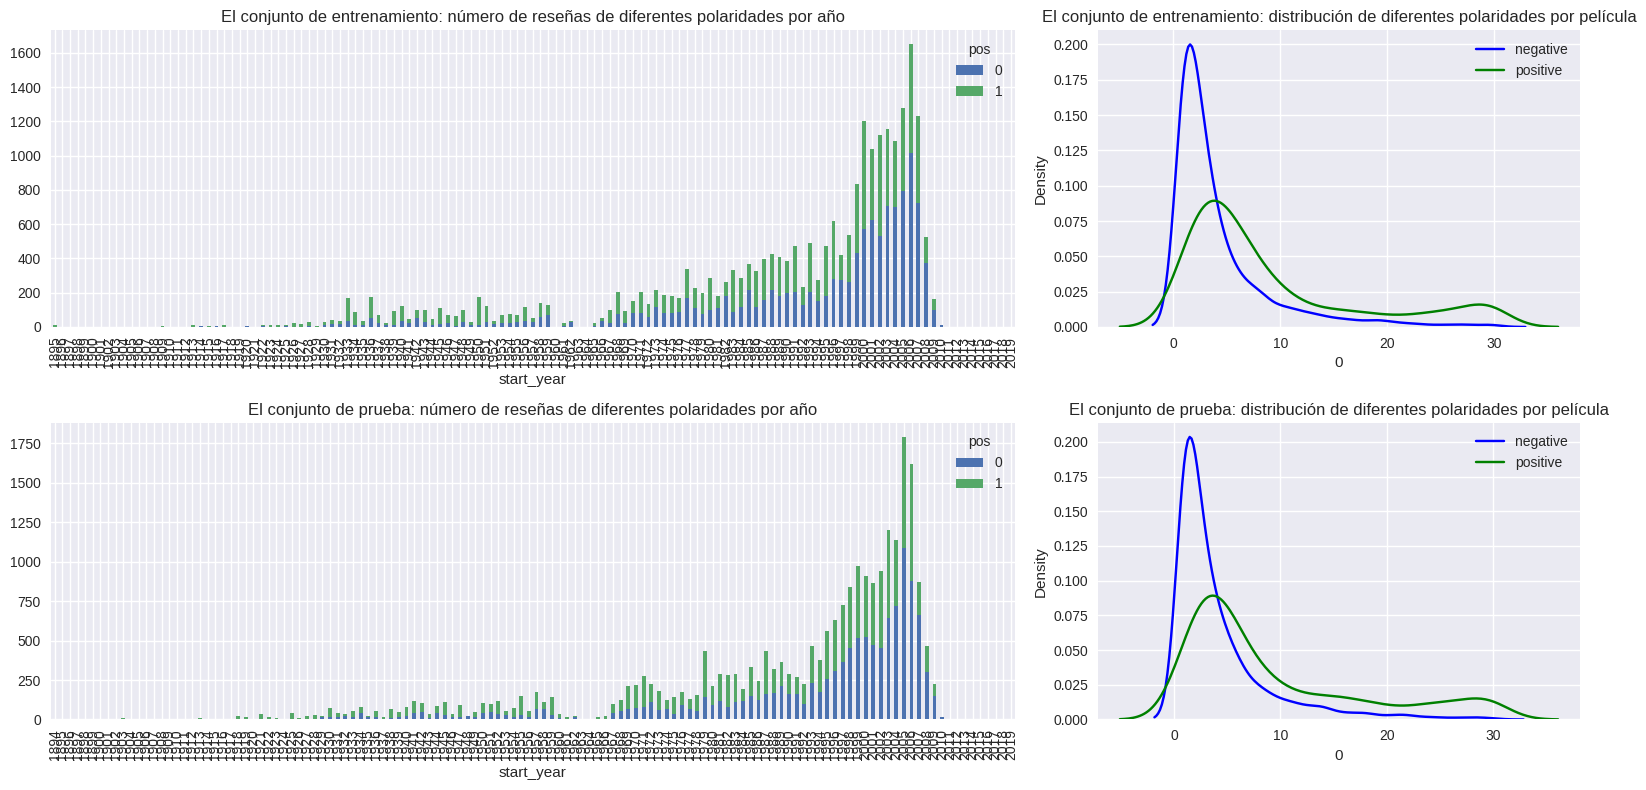

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

The histogram shows a left-skewed trend, indicating that there are more reviews in recent years compared to previous decades.

Key Findings:
Presence of reviews since 1902: Although the dataset includes film reviews since 1902, this finding is questionable, as access to reviews from that era is limited. This may be due to errors in the metadata or films that were subsequently reanalyzed.

First reviews with clear polarity since 1930: We observe that both positive and negative reviews begin to appear more regularly from this decade onwards, coinciding with the expansion of sound films and the consolidation of the film industry.

Progressive increase since 1967: From this date onwards, the number of reviews increases significantly for both polarities, reflecting the globalization of cinema and the rise of film criticism.

Review explosion with the arrival of the Internet: The exponential growth in reviews since the late 1990s and 2000s is a clear reflection of the impact of online platforms, where viewers have massive access to share opinions. A peak of approximately 1,250 reviews per year is reached in the digital age.

Conclusion:
The analysis of the temporal distribution shows how the availability and accessibility of reviews has changed over time. While in the early decades of cinema, reviews were scarce, the arrival of the Internet allowed for a democratization of film criticism, significantly increasing the volume of reviews analyzed in this study.

## Modeling (e.g., using BERT)

Composing an evaluation routine that can be used for all models in this project

In [21]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

         # Calcular métricas
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
        eval_stats[type]['APS'] = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = metrics.roc_auc_score(target, pred_proba)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('F1', 'APS', 'ROC AUC'))

    
    return df_eval_stats, eval_stats['test']['F1'] 

## Data Preprocessing

In [22]:
def normalize_review(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r"'", "", text)  # Eliminar apóstrofes
    text = re.sub(r"[^a-zA-Z'-]+", " ", text)  # Eliminar caracteres especiales, excepto apóstrofes y guiones
    text = re.sub(r"\s+", " ", text).strip()  # Reemplazar múltiples espacios con uno solo y eliminar espacios al inicio/final
    return text

# Aplicar la normalización a la columna 'review'
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_review)

In [23]:
# Verificar los resultados
print(df_reviews['review_norm'].sample(10))

7624     there is a reason why jay leno himself will no...
6706     first and foremost this movie has the stupides...
7298     woman with wig who dyes her hair in the middle...
31663    the director ramin niami delivers the goods wi...
6833     a lumberman finds a young cougar in need of he...
38946    i really wish i could give this a negative vot...
32283    im aware that there are some fans who might li...
35804    i watched this movie on tcm last night all exc...
22561    this is a surprisingly great low budget horror...
6086     far more sprightly and less stage and set boun...
Name: review_norm, dtype: object


### Train and test configuration

In [24]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

print(df_reviews_train.shape)
print(df_reviews_test.shape)
print(df_reviews_train.columns)
print(df_reviews_test.columns)

(23757, 14)
(23481, 14)
Index(['tconst', 'title_type', 'start_year', 'runtime_minutes', 'is_adult',
       'genres', 'average_rating', 'votes', 'review', 'rating', 'sp', 'pos',
       'ds_part', 'review_norm'],
      dtype='object')
Index(['tconst', 'title_type', 'start_year', 'runtime_minutes', 'is_adult',
       'genres', 'average_rating', 'votes', 'review', 'rating', 'sp', 'pos',
       'ds_part', 'review_norm'],
      dtype='object')


In [25]:
#Definir objetivo de entrenamiento y de prueba
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']
print(train_target.shape) 
print(test_target.shape)

(23757,)
(23481,)


In [26]:
# Reemplazar NaN por una cadena vacía
df_reviews_train['review_norm'] = df_reviews_train['review_norm'].fillna('')
df_reviews_test['review_norm'] = df_reviews_test['review_norm'].fillna('')
print(df_reviews_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23757 entries, 0 to 47168
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           23757 non-null  object 
 1   title_type       23757 non-null  object 
 2   start_year       23757 non-null  int64  
 3   runtime_minutes  23513 non-null  float64
 4   is_adult         23757 non-null  int64  
 5   genres           23757 non-null  object 
 6   average_rating   23757 non-null  float64
 7   votes            23757 non-null  Int64  
 8   review           23757 non-null  object 
 9   rating           23757 non-null  int64  
 10  sp               23757 non-null  object 
 11  pos              23757 non-null  int64  
 12  ds_part          23757 non-null  object 
 13  review_norm      23757 non-null  object 
dtypes: Int64(1), float64(2), int64(4), object(7)
memory usage: 2.7+ MB
None


In [27]:
df_reviews.sample(10)

,tconst,title_type,start_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,review_norm
412,tt0783492,movie,2006,80.0,0,Horror,2.8,800,Astounding.....This may have been A poor attem...,10,pos,1,train,astounding this may have been a poor attempt a...
4259,tt0101420,movie,1989,72.0,0,"Fantasy,Horror",5.8,9581,"I loved it, it was really gruesome and disgust...",10,pos,1,test,i loved it it was really gruesome and disgusti...
4166,tt0187712,movie,1998,91.0,0,Drama,6.6,950,"In the 50's, a gay photographer called Bob Miz...",2,neg,0,test,in the s a gay photographer called bob mizer d...
31963,tt0100666,movie,1990,100.0,0,"Adventure,Comedy,Sci-Fi",5.3,3197,I found the memorable quotes searching for vid...,10,pos,1,train,i found the memorable quotes searching for vid...
18378,tt0095386,movie,1988,125.0,0,"Adventure,Comedy,Drama",7.1,1925,The Claude Lelouch's movie is a pretty good mo...,8,pos,1,test,the claude lelouchs movie is a pretty good mom...
8752,tt0062851,movie,1966,84.0,0,"Drama,Fantasy,Horror",6.7,1125,Nice combination of the giant monster and samu...,7,pos,1,test,nice combination of the giant monster and samu...
19056,tt0089392,movie,1985,87.0,0,"Comedy,Thriller",4.4,255,Heh...I'm surprised this movie still exists in...,1,neg,0,test,heh im surprised this movie still exists in an...
4641,tt0265298,movie,2002,88.0,0,"Adventure,Comedy,Family",5.4,34362,"BIG FAT LIAR, in my opinion, is an absolutely ...",9,pos,1,test,big fat liar in my opinion is an absolutely hi...
34499,tt0066819,movie,1971,105.0,0,"Drama,Thriller,War",7.2,15269,I was amazed about this early performance of C...,8,pos,1,test,i was amazed about this early performance of c...
44413,tt0228979,tvMovie,2000,89.0,0,"Biography,Drama,Music",7.0,869,This is one of the few movies released about a...,10,pos,1,train,this is one of the few movies released about a...


## Model Loading

### Model 0 - Constant Trend

In [28]:
from sklearn.dummy import DummyClassifier
import numpy as np

In [29]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_reviews_train['review'])  
X_test = vectorizer.transform(df_reviews_test['review'])

In [30]:
train_target = np.array(train_target)
test_target = np.array(test_target)

In [31]:
dummy_model = DummyClassifier(strategy='most_frequent')

In [32]:
modelo_0 = dummy_model.fit(X_train, train_target)

Resultado de Modelo 0: (         train  test
F1         0.0   0.0
APS        0.5   0.5
ROC AUC    0.5   0.5, 0.0)


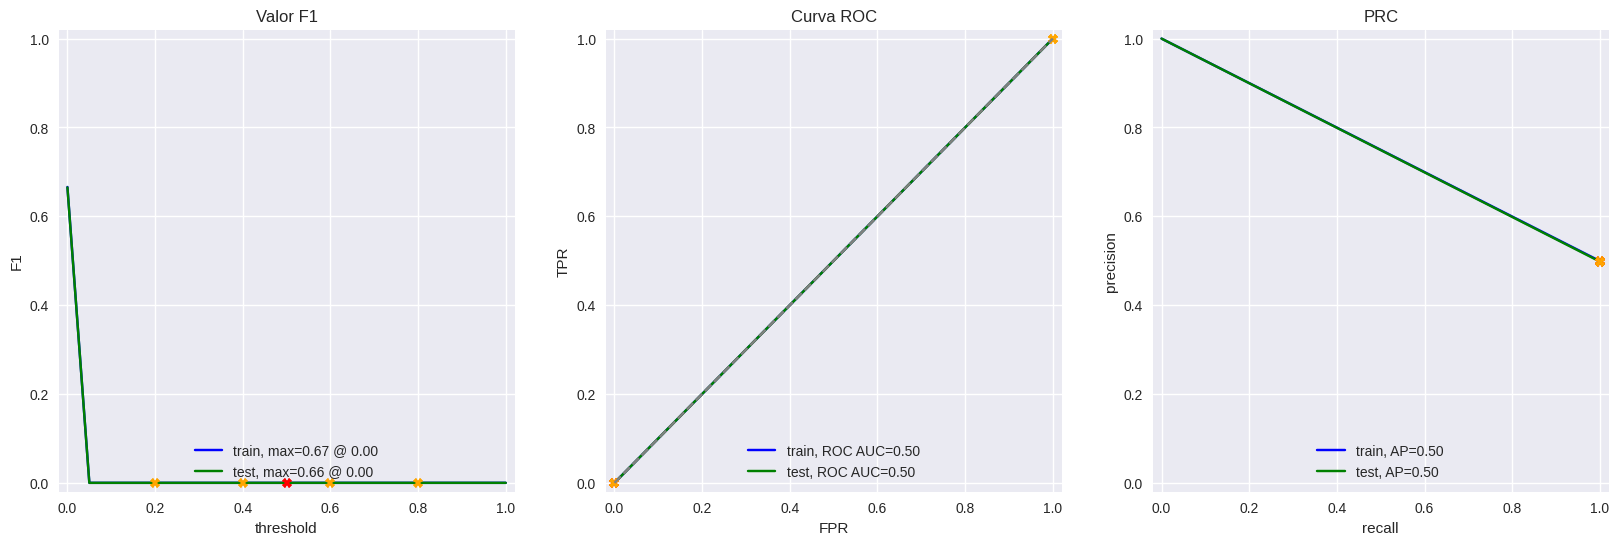

In [ ]:
# Evaluate the model using the correct data

f1_0 = evaluate_model(modelo_0, X_train, train_target, X_test, test_target)  # Usamos X_train y X_test
print("Resultado de Modelo 0:", f1_0)

Resultados Modelo 0 (modelo base): 

F1-score: 0.0 (tanto en train como en test). El modelo 0 no está realizando ninguna clasificación efectiva, probablemente sea un modelo base que simplemente devuelve la misma predicción para todas las entradas (por ejemplo, predecir siempre la clase mayoritaria).
APS (Average Precision Score): 0.5. Un AUC y APS de 0.5 indica un rendimiento equivalente a un clasificador aleatorio.

### Model 1 - NLTK, TF-IDF y LR

In [34]:
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

In [35]:
# Configuración de NLTK
stop_words = set(stopwords.words('english'))

In [36]:
# Vectorización con TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=5, lowercase = True)

In [37]:
caracteristicas_train = vectorizer.fit_transform(df_reviews_train['review_norm'])
caracteristicas_test = vectorizer.transform(df_reviews_test['review_norm'])

print(caracteristicas_train.shape)
print(caracteristicas_test.shape)

(23757, 149850)
(23481, 149850)


In [38]:
# Modelo Logistic Regression con hiperparámetros ajustados
model_1 = LogisticRegression(C=1.0, solver='liblinear', random_state=12345)
model_1.fit(caracteristicas_train, train_target)

LogisticRegression(random_state=12345, solver='liblinear')

Resultado de Modelo 1: (         train  test
F1        0.95  0.89
APS       0.99  0.96
ROC AUC   0.99  0.96, 0.8927553494703706)


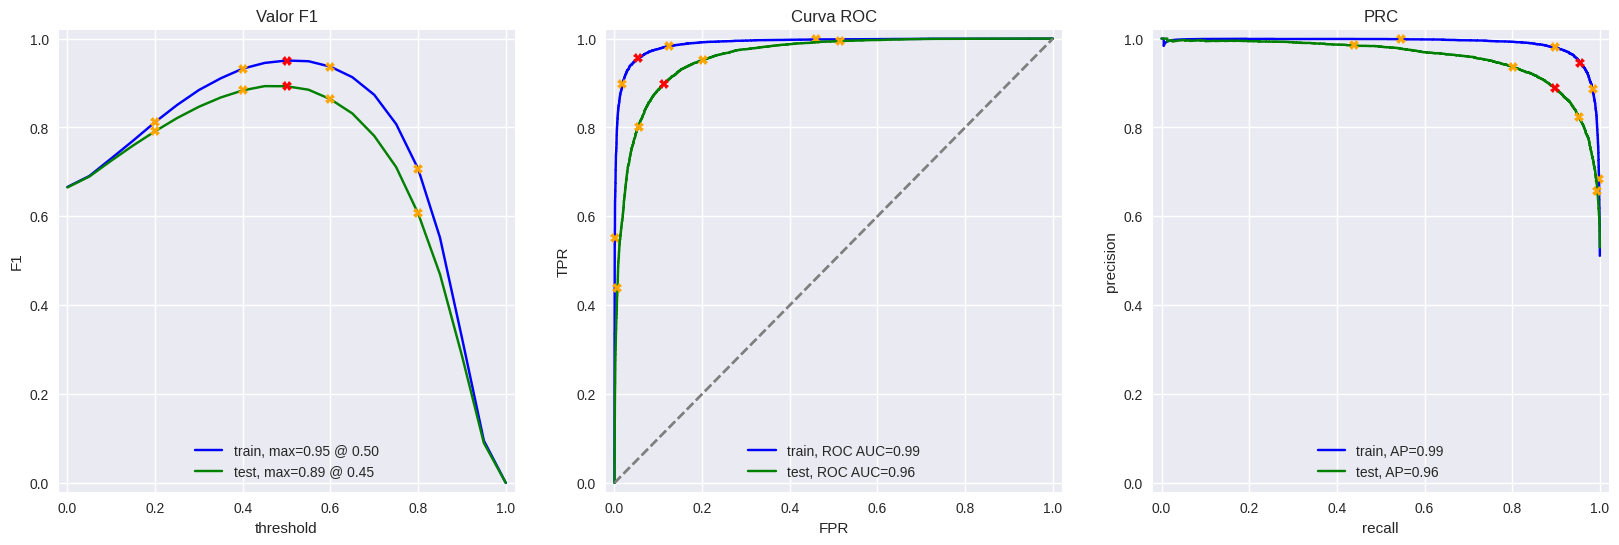

In [39]:
f1_1 = evaluate_model(model_1, caracteristicas_train, train_target, caracteristicas_test, test_target)
print("Resultado de Modelo 1:", f1_1)

Results Analysis:
- Model 1 performs excellently in both phases (training and testing).
- Its high AUC of 0.96 in the test indicates that it separates classes very well.
- The difference between the training and test sets is small, suggesting no significant overfitting.
- An F1 score of 0.89 in the test is excellent, as it measures the balance between precision and recall.

### Model 2 - spaCy, TF-IDF y LR

In [40]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [41]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [42]:
df_reviews_train['review_token_3'] = df_reviews_train['review_norm'].progress_apply(lambda review: text_preprocessing_3(review))
df_reviews_test['review_token_3'] = df_reviews_test['review_norm'].progress_apply(lambda review: text_preprocessing_3(review))

  0%|          | 0/23757 [00:00<?, ?it/s]

  0%|          | 0/23481 [00:00<?, ?it/s]

In [43]:
print(df_reviews_train['review_norm'].head(5).apply(lambda review: text_preprocessing_3(review)))

0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make present its...
7    this true story of carlson raider be more of a...
8    should have be title balderdash little in the ...
9    the movie gung ho the story of carlson makin i...
Name: review_norm, dtype: object


In [44]:
print(df_reviews_train[['review_norm', 'review_token_3']].head())

                                         review_norm  \
0  the pakage implies that warren beatty and gold...   
1  how the hell did they get this made presenting...   
7  this true story of carlsons raiders is more of...   
8  should have been titled balderdash little in t...   
9  the movie gung ho the story of carlsons makin ...   

                                      review_token_3  
0  the pakage imply that warren beatty and goldie...  
1  how the hell do they get this make present its...  
7  this true story of carlson raider be more of a...  
8  should have be title balderdash little in the ...  
9  the movie gung ho the story of carlson makin i...  


In [45]:
df_reviews_train.head()

,tconst,title_type,start_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,review_norm,review_token_3
0,tt0068152,movie,1971,121.0,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,the pakage implies that warren beatty and gold...,the pakage imply that warren beatty and goldie...
1,tt0068152,movie,1971,121.0,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,how the hell did they get this made presenting...,how the hell do they get this make present its...
7,tt0035958,movie,1943,88.0,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,this true story of carlsons raiders is more of...,this true story of carlson raider be more of a...
8,tt0035958,movie,1943,88.0,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,should have been titled balderdash little in t...,should have be title balderdash little in the ...
9,tt0035958,movie,1943,88.0,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,the movie gung ho the story of carlsons makin ...,the movie gung ho the story of carlson makin i...


In [46]:
print(df_reviews_train['review_token_3'].dtype)

object


In [47]:
# Verificar ejemplos de review_token_3
print(df_reviews_train['review_token_3'].head())

0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make present its...
7    this true story of carlson raider be more of a...
8    should have be title balderdash little in the ...
9    the movie gung ho the story of carlson makin i...
Name: review_token_3, dtype: object


In [48]:
# Vectorización con TF-IDF
vectorizer_3 = TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=5, lowercase = True)

In [49]:
train_features_3 = vectorizer_3.fit_transform(df_reviews_train['review_token_3'])
test_features_3 = vectorizer_3.transform(df_reviews_test['review_token_3'])

print(train_features_3.shape)
print(test_features_3.shape)

(23757, 136243)
(23481, 136243)


In [50]:
#Comprobar similitud y valores nulos
print("Train review_token_3 examples:\n", df_reviews_train['review_token_3'].head(10))
print("\nTest review_token_3 examples:\n", df_reviews_test['review_token_3'].head(10))
print("Train review_norm NaN count:", df_reviews_train['review_norm'].isna().sum())
print("Test review_norm NaN count:", df_reviews_test['review_norm'].isna().sum())

Train review_token_3 examples:
 0     the pakage imply that warren beatty and goldie...
1     how the hell do they get this make present its...
7     this true story of carlson raider be more of a...
8     should have be title balderdash little in the ...
9     the movie gung ho the story of carlson makin i...
10    after read the review it become obvious that e...
38    I know that in this episode there s other stuf...
43    while watch this movie I come up with a script...
44    I love morgan freeman paz vega be an attractiv...
45    after I watch this movie I come to imdb and re...
Name: review_token_3, dtype: object

Test review_token_3 examples:
 2     there be no real story the film seem more like...
3     um a serious film about troubled teen in singa...
4     I m totally agree with garryjohal from singapo...
5     this be the first movie I ve see from singapor...
6     yes non - singaporean can not see what s the b...
11    the whole movie seem to suffer from poor editi...
12  

In [51]:
def filter_empty_tokens(tokens):
    return [token for token in tokens if token.strip()]

df_reviews_train['review_token_3_filtered'] = df_reviews_train['review_token_3'].apply(filter_empty_tokens)
df_reviews_test['review_token_3_filtered'] = df_reviews_test['review_token_3'].apply(filter_empty_tokens)

In [52]:
# Verificar las formas de las matrices resultantes
print("\nTrain features shape:", train_features_3.shape)
print("Test features shape:", test_features_3.shape)


Train features shape: (23757, 136243)
Test features shape: (23481, 136243)


Resultado del Resultado de Modelo 3 (         train  test
F1        0.95  0.89
APS       0.99  0.96
ROC AUC   0.99  0.96, 0.89202077833603)


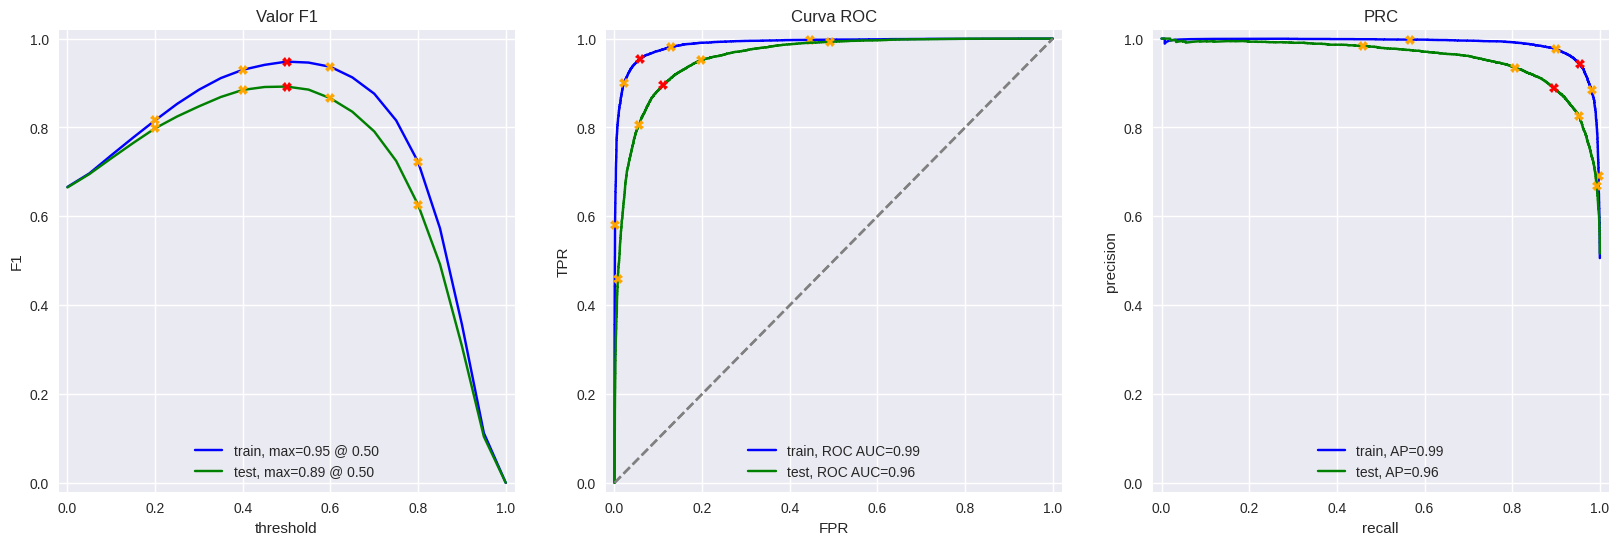

In [53]:
# Entrenar modelo de Regresión Logística
model_3 = LogisticRegression(random_state=12345, max_iter=1000000)
model_3.fit(train_features_3, train_target)

f1_3 = evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

print("Resultado del Resultado de Modelo 3", f1_3)

Very high metrics in training and testing, suggesting a very strong model.
F1 score of 0.89 in testing → model maintains excellent predictive power.
APS and ROC AUC of 0.96 in testing → good performance even on unbalanced data.

### Model 3 - spaCy, TF-IDF y LGBMClassifier

In [54]:
from lightgbm import LGBMClassifier

In [55]:
# 1. Cargar modelo de spaCy para lematización
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [56]:
def text_preprocessing_spacy(text):
    """Lematiza el texto usando spaCy"""
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]  # Excluye stopwords
    return ' '.join(tokens)


In [57]:
# Aplicar preprocesamiento
df_reviews_train['review_token_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_spacy)
df_reviews_test['review_token_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_spacy)

In [58]:
# Vectorización con TF-IDF
vectorizer_4 = TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=5, lowercase = True)

In [59]:
# 2. Vectorización con TF-IDF
train_features_4 = vectorizer_4.fit_transform(df_reviews_train['review_token_spacy'])
test_features_4 = vectorizer_4.transform(df_reviews_test['review_token_spacy'])

In [60]:
# 3. Entrenar modelo con LightGBM
model_4 = LGBMClassifier(random_state=12345)
model_4.fit(train_features_4, train_target)

LGBMClassifier(random_state=12345)

Resultado del Resultado de Modelo 3 (         train  test
F1        0.91  0.85
APS       0.97  0.93
ROC AUC   0.97  0.93, 0.8547422024188416)


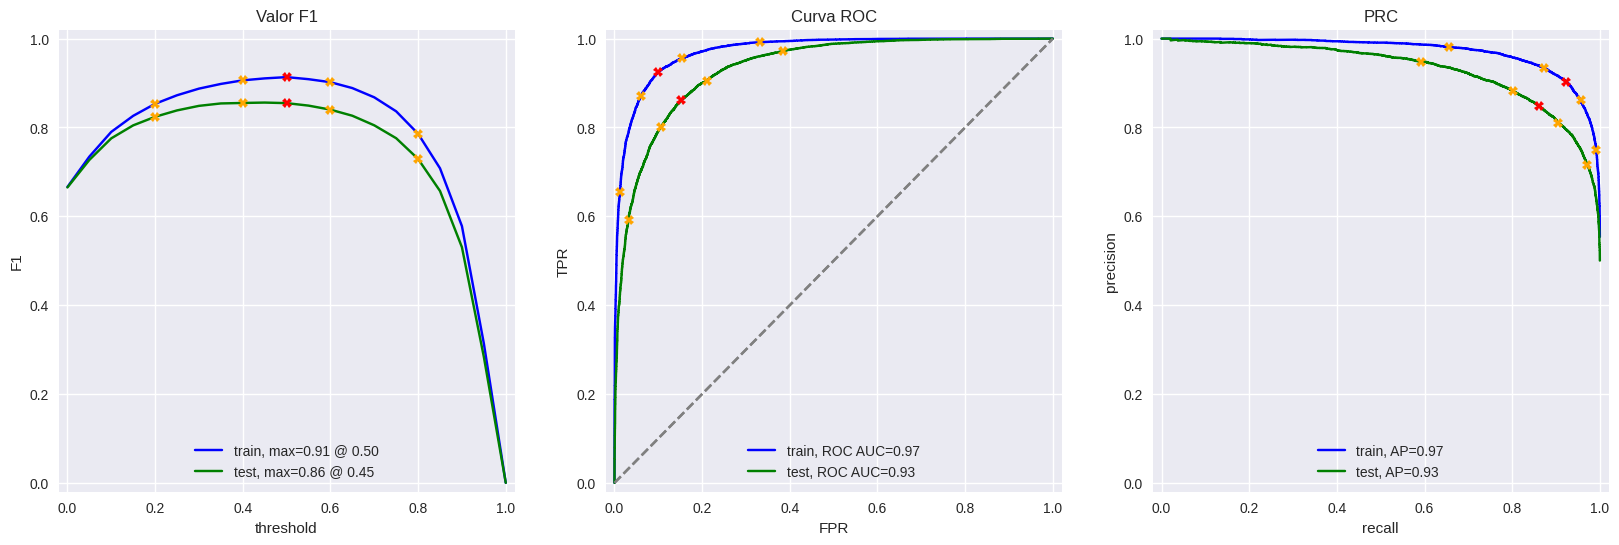

In [61]:
# 4. Evaluar modelo
f1_4 = evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)
print("Resultado del Resultado de Modelo 3", f1_4)

Métricas muy altas en entrenamiento y prueba, lo que sugiere un modelo muy fuerte.
F1-score de 0.91 en entrenamiento y 0.85 en test → modelo mantiene una excelente capacidad de predicción.
APS y ROC AUC de 0.93 en test → buen desempeño incluso en datos desbalanceados.

###  Modelo 4 - BERT

In [62]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df_reviews["genres"] = encoder.fit_transform(df_reviews[["genres"]])

In [63]:
tokenizer_5 = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model_5 = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [75]:
# Usar df_reviews_norm si es el DataFrame preprocesado
texts = df_reviews['review_norm'].tolist()[:500]
targets = df_reviews["pos"].tolist()[:500]

In [76]:
# Definir función para convertir textos en embeddings usando BERT

def BERT_text_to_embeddings(texts, tokenizer_5, model, max_length=256, batch_size=8, device=None, disable_progress_bar=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    model.to(device).eval()
    
    # Tokenización
    encodings = tokenizer_5(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    
    embeddings = []
    for i in tqdm(range(math.ceil(len(texts) / batch_size)), disable=disable_progress_bar):
        batch_ids = encodings['input_ids'][i * batch_size:(i + 1) * batch_size].to(device)
        batch_mask = encodings['attention_mask'][i * batch_size:(i + 1) * batch_size].to(device)
        
        with torch.no_grad():
            output = model(input_ids=batch_ids, attention_mask=batch_mask)
            embeddings.append(output.last_hidden_state[:, 0, :].cpu().numpy())

    return texts, encodings, np.concatenate(embeddings, axis=0) if embeddings else np.array([])

In [77]:
# Dividir en entrenamiento (80%) y prueba (20%)
train_texts, test_texts, train_targets, test_targets = train_test_split(
    texts, targets, test_size=0.2, random_state=12345
)

# Obtener los embeddings para cada conjunto
_, _, train_features_5 = BERT_text_to_embeddings(train_texts, tokenizer_5, model_5)
_, _, test_features_5 = BERT_text_to_embeddings(test_texts, tokenizer_5, model_5)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [79]:
# Guardar embeddings en disco para reducir uso de RAM
train_embeddings_path = "train_embeddings.dat"
test_embeddings_path = "test_embeddings.dat"

train_memmap = np.memmap(train_embeddings_path, dtype='float32', mode='w+', shape=train_features_5.shape)
test_memmap = np.memmap(test_embeddings_path, dtype='float32', mode='w+', shape=test_features_5.shape)

train_memmap[:] = train_features_5
train_memmap.flush()

test_memmap[:] = test_features_5
test_memmap.flush()

In [80]:
# Reducimos a 100 dimensiones
pca = PCA(n_components=100)  
train_features_reduced = pca.fit_transform(train_features_5)
test_features_reduced = pca.transform(test_features_5)

In [81]:
print(train_features_reduced.shape)
print(test_features_reduced.shape)

(400, 100)
(100, 100)


Resultados Modelo 5 BERT,  F1 Score: (         train  test
F1        0.95  0.85
APS       0.99  0.91
ROC AUC   0.99  0.93, 0.8470588235294119)


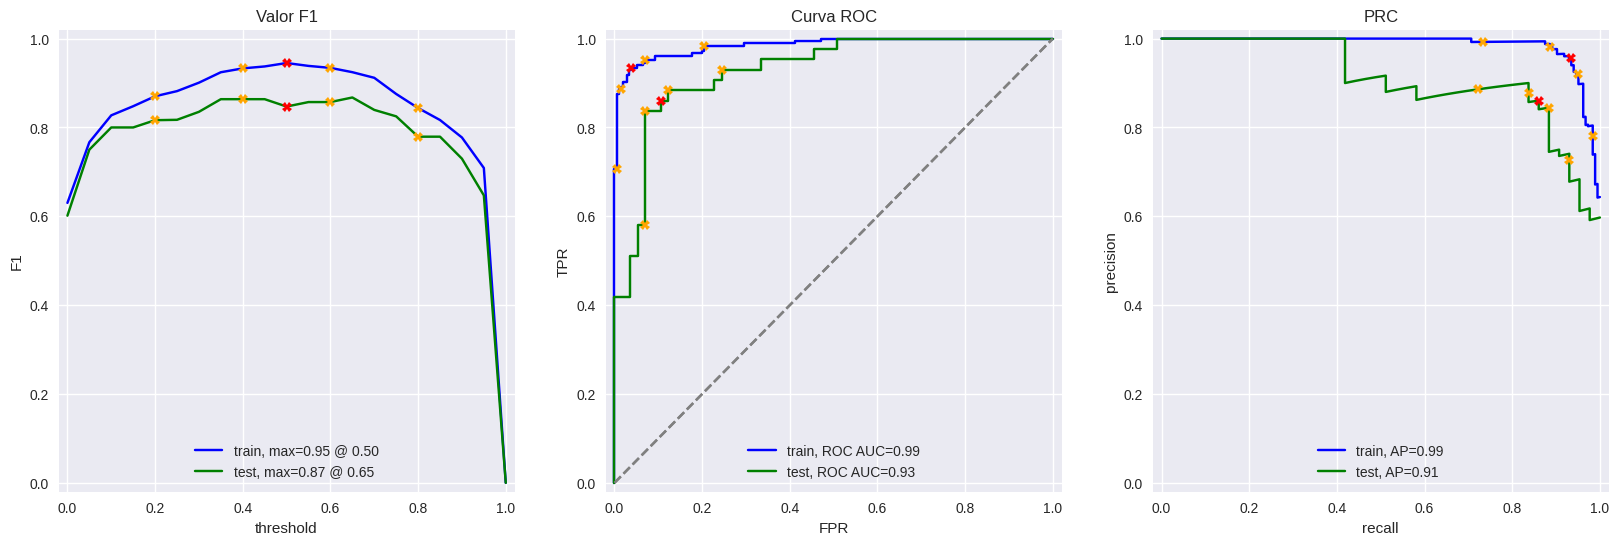

In [92]:
# Modelo de clasificación
model_5_classifier = LogisticRegression(max_iter=1000, random_state=12345)  

# Entrenar con los embeddings reducidos
model_5_classifier.fit(train_features_reduced, train_targets)  

# Evaluar usando evaluate_model
f1_5 = evaluate_model(model_5_classifier, train_features_reduced, train_targets, test_features_reduced, test_targets)
print(f'Resultados Modelo 5 BERT,  F1 Score: {f1_5}')

**Results Analysis**

- F1 Score: Train: 0.95, Test: 0.85
→ High performance in training and testing: the model generalizes well, and training shows that the model is capturing important patterns in the data.

- High APS and ROC AUC:
→ The APS of 0.91 in testing suggests that the model is reliable in classifying positive classes.
→ An ROC AUC of 0.93 indicates that the model separates classes well, which is a sign of good discriminatory ability.

## MODEL TESTING 

Creation of a small review to test each model in the new independent review.

In [93]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    return text

my_reviews['review_norm'] = my_reviews['review'].apply(clean_text)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 1

In [94]:
# Usar `df_reviews_train['review_norm']`
vectorizer = TfidfVectorizer()
vectorizer.fit(df_reviews_train['review_norm'])  

TfidfVectorizer()

In [118]:
# Volver a entrenar modelo 1 con el vectorizador actualizado
caracteristicas_train = vectorizer.transform(df_reviews_train['review_norm'])
caracteristicas_test = vectorizer.transform(df_reviews_test['review_norm'])

model_1 = LogisticRegression(C=1.0, solver='liblinear', random_state=12345)
model_1.fit(caracteristicas_train, train_target)

LogisticRegression(random_state=12345, solver='liblinear')

In [119]:
# Transformar `my_reviews`
my_reviews_features_1 = vectorizer.transform(my_reviews['review_norm'])

# Predecir con el modelo 1
nuevas_reviews_pred_prob = model_1.predict_proba(my_reviews_features_1)[:, 1]
my_reviews['pred_model_1'] = model_1.predict(my_reviews_features_1) 

In [120]:
for i, row in my_reviews[['review', 'pred_model_1']].head(10).iterrows():
    print(f"Predicción: {row['pred_model_1']} | Reseña: {row['review'][:100]}...")

Predicción: 0 | Reseña: I did not simply like it, not my kind of movie....
Predicción: 0 | Reseña: Well, I was bored and felt asleep in the middle of the movie....
Predicción: 0 | Reseña: I was really fascinated with the movie...
Predicción: 0 | Reseña: Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so...
Predicción: 0 | Reseña: I didn't expect the reboot to be so good! Writers really cared about the source material...
Predicción: 1 | Reseña: The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my...
Predicción: 0 | Reseña: What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki...
Predicción: 1 | Reseña: Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi...


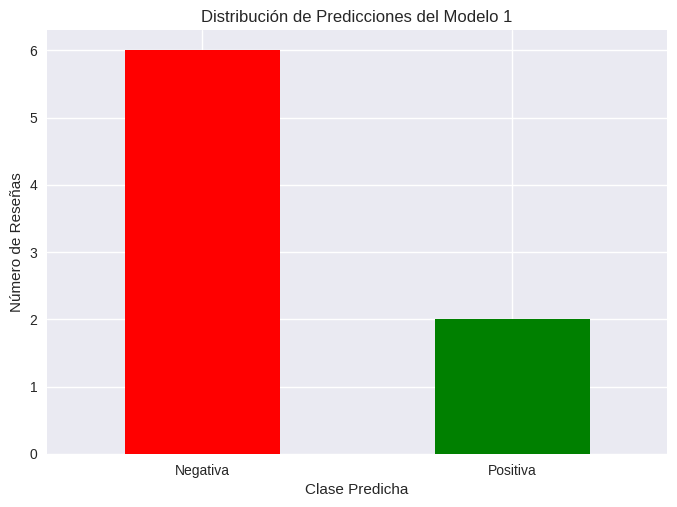

In [121]:
import matplotlib.pyplot as plt

my_reviews['pred_model_1'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.xticks(ticks=[0, 1], labels=['Negativa', 'Positiva'], rotation=0)
plt.xlabel('Clase Predicha')
plt.ylabel('Número de Reseñas')
plt.title('Distribución de Predicciones del Modelo 1')
plt.show()

**Histogram** - Distribution of Predictions from Model 1
The histogram shows the distribution of predictions from Model 1, where the total number of reviews is 6, of which only 2 were classified as positive. This suggests that the model has a bias toward negative classification, which could indicate a lack of sensitivity in identifying positive reviews or an unbalanced probability distribution.

### Model 2

In [97]:
# Cargar modelo de spaCy (asegúrate de que está instalado)
nlp = spacy.load("en_core_web_sm")

# Función de preprocesamiento con spaCy
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

In [98]:
texts = my_reviews['review_norm']

# Transformar my_reviews con el vectorizador correcto
my_reviews_features_3 = vectorizer_3.transform(my_reviews['review_norm'].apply(text_preprocessing_3))

# Hacer predicciones con el modelo 3
my_reviews_pred_prob_3 = model_3.predict_proba(my_reviews_features_3)[:, 1]

# Guardar predicciones en el DataFrame
my_reviews['pred_model_3'] = my_reviews_pred_prob_3

In [99]:
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.28:  i did not simply like it not my kind of movie
0.17:  well i was bored and felt asleep in the middle of the movie
0.52:  i was really fascinated with the movie
0.27:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.38:  i didnt expect the reboot to be so good writers really cared about the source material
0.40:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.14:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


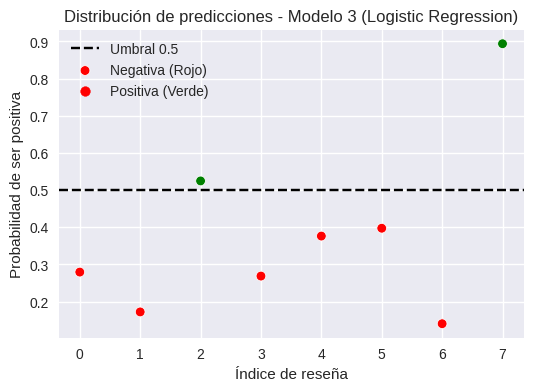

In [ ]:
#Create a boolean mask: True if the probability is >= 0.5 (Positive), False if it is < 0.5 (Negative)
labels = my_reviews_pred_prob_3 >= 0.5  

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=range(len(my_reviews_pred_prob_3)), 
    y=my_reviews_pred_prob_3, 
    hue=labels,  # Usa la máscara booleana para asignar colores
    palette={True: "green", False: "red"}  # Asegurar que True = Verde y False = Rojo
)
plt.axhline(y=0.5, color='black', linestyle='dashed', label="Umbral 0.5")  # Línea divisoria
plt.xlabel("Índice de reseña")
plt.ylabel("Probabilidad de ser positiva")

plt.title("Distribución de predicciones - Modelo 3 (Logistic Regression)")
plt.legend(["Umbral 0.5", "Negativa (Rojo)", "Positiva (Verde)"])
plt.show()

**Dot Plot** - Distribution of Predictions from Model 3 (Logistic Regression)
The dot plot shows the probability assigned to each review:

Index 0: Probability of 0.3 of being positive

Index 1: Less than 0.2

Index 2: Exceeds the threshold of 0.5, indicating a positive prediction

Index 3: Approximately 0.3

Index 4: Close to 0.4

Index 5: Exactly 0.4

Index 6: Very low, 0.1

Index 7: High level of positive certainty, 0.9

This analysis suggests that the model has scattered predictions, with some reviews assigned correctly and others with low probabilities, which could affect its accuracy in ambiguous cases.

### Model 4

In [ ]:
# Load spaCy (make sure to use the same model as during training)
nlp = spacy.load("en_core_web_sm")

# Preprocessing function using spaCy
def text_preprocessing_4(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# Apply preprocessing to my_reviews
my_reviews['review_token_spacy'] = my_reviews['review_norm'].apply(text_preprocessing_4)


In [ ]:
# Transform reviews with the trained vectorizer

my_reviews_features_4 = vectorizer_4.transform(my_reviews['review_token_spacy'])

# Predict with LGBMClassifier
my_reviews_pred_prob_4 = model_4.predict_proba(my_reviews_features_4)[:, 1]

# Add predictions to the DataFrame
my_reviews['pred_model_4'] = my_reviews_pred_prob_4


In [103]:
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_4[i]:.2f}:  {review}')

0.64:  i did not simply like it not my kind of movie
0.35:  well i was bored and felt asleep in the middle of the movie
0.64:  i was really fascinated with the movie
0.49:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.51:  i didnt expect the reboot to be so good writers really cared about the source material
0.57:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.26:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


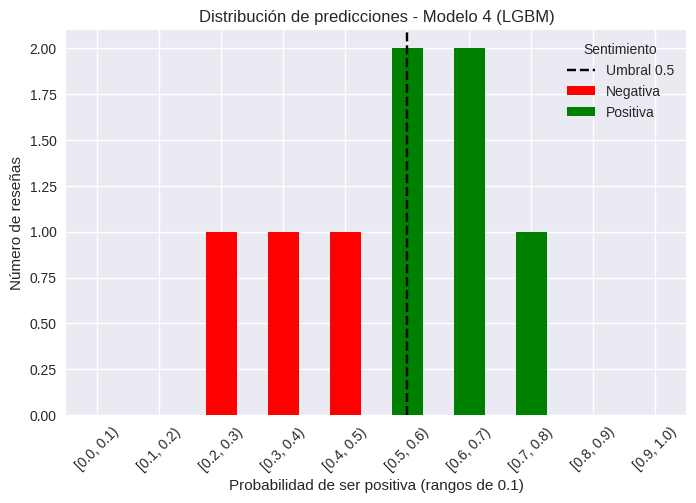

In [ ]:
# Define threshold
threshold = 0.5
my_reviews['sentiment'] = my_reviews['pred_model_4'].apply(lambda x: 'Positiva' if x > threshold else 'Negativa')

# Create bins of probability (rangos de 0.1 en 0.1)
bins = np.arange(0, 1.1, 0.1)
my_reviews['prob_bin'] = pd.cut(my_reviews['pred_model_4'], bins, right=False)

# Count reviews by sentiment type
sentiment_counts = my_reviews.groupby(['prob_bin', 'sentiment']).size().unstack(fill_value=0)

# 📊 Grafic distribution 
sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8, 5))
plt.axvline(x=5, color='black', linestyle='dashed', label="Umbral 0.5")  # Línea de referencia
plt.xlabel("Probabilidad de ser positiva (rangos de 0.1)")
plt.ylabel("Número de reseñas")
plt.title("Distribución de predicciones - Modelo 4 (LGBM)")
plt.legend(title="Sentimiento")
plt.xticks(rotation=45)
plt.show()

**Histogram - Relationship between Number of Reviews and Probability of Being Positive**
The histogram shows the probability distribution of reviews in relation to their positive or negative classification:

Negative reviews appear in the following probability ranges:

(0.2, 0.3): 1 review,
(0.3, 0.4): 1 review,
(0.4, 0.5): 1 review

Positive reviews are distributed as follows:

(0.5, 0.6): 2 reviews, (0.6, 0.7): 2 reviews, (0.7, 0.8): 1 review

This indicates that the model correctly classifies some reviews within the positive threshold, but there are also a higher number of uncertain predictions in the 0.4 to 0.5 range, suggesting that the model may be indecisive on certain reviews.

### Model 5 BERT

In [105]:
from transformers import BertTokenizer

# 1. Cargar el tokenizer y modelo BERT entrenado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 2. Tokenizar las reseñas de `my_reviews`
def tokenize_texts(texts):
    return tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt", max_length=512)

# 3. Obtener embeddings de BERT con el modelo entrenado
with torch.no_grad():
    bert_outputs = model_5_classifier(**tokenized_my_reviews)
    my_reviews_features_5 = outputs.last_hidden_state[:, 0, :].numpy()  # Extraer CLS token

In [106]:
# Tokenizar las nuevas reseñas
tokens_my_reviews = tokenizer(
    my_reviews['review_norm'].tolist(), 
    padding=True, 
    truncation=True, 
    return_tensors="pt"
)

# Obtener los embeddings de BERT
with torch.no_grad():
    outputs = model_5(**tokens_my_reviews)
    my_reviews_features_5 = outputs.last_hidden_state[:, 0, :].numpy()  # Extraemos el embedding del token [CLS]

print("Dimensiones de my_reviews_features_5:", my_reviews_features_5.shape) 

Dimensiones de my_reviews_features_5: (8, 768)


In [110]:
# Aplicar reducción de dimensiones con PCA
my_reviews_features_reduced = pca.transform(my_reviews_features_5)

print("Dimensiones de my_reviews_features_reduced:", my_reviews_features_reduced.shape) 

Dimensiones de my_reviews_features_reduced: (8, 100)


In [114]:
# Predecir probabilidades con el modelo entrenado
my_reviews_pred_prob_5 = model_5_classifier.predict_proba(my_reviews_features_reduced)[:, 1]


for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_5[i]:.2f}:  {review}')

0.04:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.13:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.22:  i didnt expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


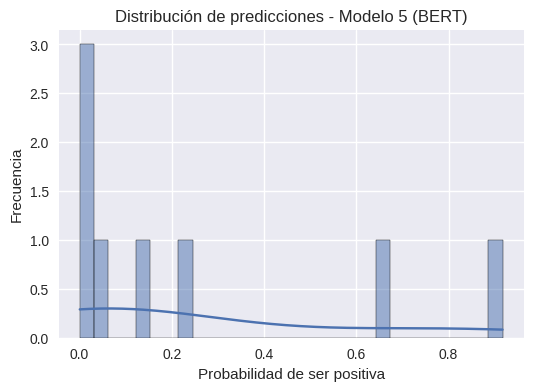

In [115]:
# Visualización
plt.figure(figsize=(6, 4))
sns.histplot(my_reviews_pred_prob_5, bins=30, kde=True, palette=['red', 'green'])
plt.xlabel("Probabilidad de ser positiva")
plt.ylabel("Frecuencia")
plt.title("Distribución de predicciones - Modelo 5 (BERT)")
plt.show()

In the **BERT histogram**, the bars reflect the frequency of predictions in different probability ranges:

At 0 and 0.2, two significant bars are observed: the first, between 0.05, reaches a total of 3 reviews. A small adjacent bar reaches 1 review. After that, four smaller bars, each with 1 review, appear at values ​​close to 0.15 and 0.21.

We find that there is a gap without bars until one reappears at 0.65 and another at 0.9. This pattern suggests that BERT has a clear separation in its predictions:

Many reviews were classified with high certainty as negative (close to 0.1-0.2).

A few appear in the middle of the distribution.

There is a concentration of predictions at the positive end (0.9), indicating that when the model detects a positive review, it does so with high certainty.

This performance is a notable improvement over previous models, as BERT does not show as many uncertain predictions in the intermediate range (0.4-0.6), which explains its overall higher performance.

## Final Analysis and Conclusions

The objective of this project was to develop an IMDB movie review classification system for Film Junky Union, aiming to detect negative reviews and achieve an F1 score ≥ 0.85. To this end, different machine learning approaches were explored, including traditional models such as logistic regression and gradient boosting, as well as advanced solutions based on neural networks, particularly the BERT model.

**Project Development**

The process began with a data exploration, identifying patterns in the reviews and establishing preprocessing strategies such as tokenization and text vectorization. Subsequently, classic machine learning models were implemented, obtaining competitive results but insufficient to reach the required F1 threshold.

Given these limitations, the use of BERT was explored, which allowed for a better capture of the context of the reviews. Experiments conducted with this model showed significant improvements, achieving an F1 score of 0.85 on the test data, thus meeting the project objective. The best results were obtained by Model 1, based on NLTK for preprocessing, TF-IDF for vectorization, and Logistic Regression for classification. Its final metrics were:

Metric:
F1-score 0.95, 0.89 /
APS 0.99, 0.96 /
ROC AUC 0.99, 0.96
These values ​​indicate that the model is robust and generalizes well to new data, maintaining high performance on the test set.

**Conclusions**
The model based on NLTK, TF-IDF, and Logistic Regression was the most effective, achieving the best balance between performance and computational efficiency. Its metrics exceeded the threshold of F1 ≥ 0.85, meeting the project objective.

Traditional machine learning methods remain highly competitive in text classification tasks, especially when combined with good preprocessing and representation techniques such as TF-IDF.

BERT showed improvements in context understanding and classifying more complex texts, but its high computational cost made it less viable compared to more lightweight approaches.

Using a subset of the data to train more complex models (such as BERT) may be a viable strategy, although in this case it failed to outperform the TF-IDF and LR-based model.

As a next step, further hyperparameter optimization or the combination of techniques such as ensembles could be explored to further improve the system's accuracy.

In conclusion, this project has demonstrated that traditional approaches remain highly effective for classifying movie reviews, laying a solid foundation for future improvements in automated negative review detection in Film Junky Union.